In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils
import time

In [2]:
device= torch.device("cuda:1")
#device= torch.device("cpu")
print(device)
print(torch.cuda.get_device_name(1))

cuda:1
TITAN V


In [3]:
from utils import check_cifar_dataset_exists
data_path=check_cifar_dataset_exists()

train_data=torch.load(data_path+'cifar/train_data.pt')
train_label=torch.load(data_path+'cifar/train_label.pt')
test_data=torch.load(data_path+'cifar/test_data.pt')
test_label=torch.load(data_path+'cifar/test_label.pt')

print(train_data.size())
print(test_data.size())

torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


In [4]:
class Stem(nn.Module):

    def __init__(self):

        super(Stem, self).__init__()
        
        #----------------------- stem block start ----------------------------
        
        #self.padding = nn.ZeroPad2d((133,134,133,134))
        #self.padding = nn.ReplicationPad2d((133,134,133,134))
        
        self.resize = nn.UpsamplingBilinear2d(size=(299,299))
        
        #3 x 299 x 299 --> 32 x 149 x 149  , VALID Padding 
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=0 ) 
        
        self.bn1a = nn.BatchNorm2d(32,affine=True, eps=0.001,momentum=0.1)
        
        #32 x 149 x 149 --> 32 x 147 x 147  , VALID Padding 
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0 )
        
        self.bn1b = nn.BatchNorm2d(32,affine=True, eps=0.001,momentum=0.1)
        
        #32 x 147 x 147 --> 64 x 147 x 147  , SAME Padding 
        self.conv1c = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1 )
        
        self.bn1c = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #======================== Filter concat 1 =============================
        
        #64 x 147 x 147 --> 64 x 73 x 73, kernel size = 3, VALID Padding  
        self.pool1  = nn.MaxPool2d(kernel_size=3, stride=2, padding=0 )
        
        #64 x 147 x 147 --> 96 x 73 x 73  , VALID Padding
        self.conv2a = nn.Conv2d(64, 96, kernel_size=3, stride=2, padding=0 )
        
        self.bn2a = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #======================== Filter concat 1 =============================
        
        #======================== Filter concat 2 =============================       
        
        #160 x 73 x 73 --> 64 x 73 x 73  , SAME Padding   Find out the size of output
        self.conv3a = nn.Conv2d(160, 64, kernel_size=1, padding=0 )
        
        self.bn3a = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #64 x 73 x 73 --> 96 x 71 x 71  , VALID Padding   Find out the size of output
        self.conv3b = nn.Conv2d(64, 96, kernel_size=3, padding=0 )
        
        self.bn3b = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #160 x 73 x 73 --> 64 x 73 x 73  , SAME Padding   Might be combined with self.conv1e1
        self.conv4a = nn.Conv2d(160, 64, kernel_size=1, padding=0 )
        
        self.bn4a = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #64 x 73 x 73 --> 64 x 73 x 73  , SAME Padding   Find out the size of output
        self.conv4b = nn.Conv2d(64, 64, kernel_size=[7,1], padding=[3,0] )
        
        self.bn4b = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #64 x 73 x 73 --> 64 x 73 x 73  , SAME Padding   Find out the size of output
        self.conv4c = nn.Conv2d(64, 64, kernel_size=[1,7], padding=[0,3]  )
        
        self.bn4c = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #64 x 73 x 73 --> 96 x 71 x 71  , VALID Padding   Might be combined with self.conv1e2
        self.conv4d = nn.Conv2d(64, 96, kernel_size=3, padding=0 )
        
        self.bn4d = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #======================== Filter concat 2 ============================= 
        
        #======================== Filter concat 3 =============================
        
        #192 x 71 x 71 --> 192 x 35 x 35  , VALID Padding 
        self.conv5a = nn.Conv2d(192, 192, kernel_size=3, stride=2, padding=0 )
        
        self.bn5a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
         
        #192 x 71 x 71 --> 192 x 35 x 35, kernel size = 3, VALID Padding
        self.pool2  = nn.MaxPool2d(kernel_size=3, stride=2, padding=0 )
        
        #======================== Filter concat 3 =============================
        
        #----------------------- stem block finish ----------------------------
        
    def forward(self, x):

        # block 1: 
        #x = self.padding(x)
        x= self.resize(x)
        
        x = self.conv1a(x)
        x = self.bn1a(x)
        x = F.relu(x)
        
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = F.relu(x)
        
        
        x = self.conv1c(x)
        x = self.bn1c(x)
        x = F.relu(x)
        
        
        xP = self.pool1(x)
        xC = self.conv2a(x)
        xC = self.bn2a(xC)
        xC = F.relu(xC)
        xFC1 = torch.cat((xP, xC), 1)
        
        y = self.conv3a(xFC1)
        y = self.bn3a(y)
        y = F.relu(y)
        
        y = self.conv3b(y)
        y = self.bn3b(y)
        y = F.relu(y)

        z = self.conv4a(xFC1)
        z = self.bn4a(z)
        z = F.relu(z)
        z = self.conv4b(z)
        z = self.bn4b(z)
        z = F.relu(z)
        z = self.conv4c(z)
        z = self.bn4c(z)
        z = F.relu(z)
        z = self.conv4d(z)
        z = self.bn4d(z)
        z = F.relu(z)
        
        # Above code or this one?
        #z = self.conv3a(xFC1)
        #z = F.relu(z)
        #z = self.conv4b(z)
        #z = F.relu(z)
        #z = self.conv4c(xFC1)
        #z = F.relu(z)
        #z = self.conv3b(z)
        #z = F.relu(z)
        
        xFC2 = torch.cat((y, z), 1)
        
        xP = self.pool2(xFC2)
        xC = self.conv5a(xFC2)
        xC = self.bn5a(xC)
        xC = F.relu(xC)
        xFC3 = torch.cat((xP, xC), 1)   
        #print('Stem Done')
        
        return xFC3

In [5]:
class InceptionA(nn.Module):

    def __init__(self):

        super(InceptionA, self).__init__()
        
        #----------------------- InceptionA block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #384 x 35 x 35 --> 384 x 35 x 35  , kernel size = 3, SAME Padding
        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1 )
        
        #384 x 35 x 35 --> 96 x 35 x 35  , SAME Padding 
        self.conv1a = nn.Conv2d(384, 96, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #block 2
        #384 x 35 x 35 --> 96 x 35 x 35  , SAME Padding 
        self.conv2a = nn.Conv2d(384, 96, kernel_size=1, padding=0 ) 
        self.bn2a = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #384 x 35 x 35 --> 64 x 35 x 35  , SAME Padding 
        self.conv3a = nn.Conv2d(384, 64, kernel_size=1, padding=0 )
        self.bn3a = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #64 x 35 x 35 --> 96 x 35 x 35  , SAME Padding 
        self.conv3b = nn.Conv2d(64, 96, kernel_size=3, padding=1 )
        self.bn3b = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #block 4
        #384 x 35 x 35 --> 64 x 35 x 35  , SAME Padding 
        self.conv4a = nn.Conv2d(384, 64, kernel_size=1, padding=0 )
        self.bn4a = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)

        #64 x 35 x 35 --> 96 x 35 x 35  , SAME Padding 
        self.conv4b = nn.Conv2d(64, 96, kernel_size=3, padding=1 )
        self.bn4b = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #96 x 35 x 35 --> 96 x 35 x 35  , SAME Padding 
        self.conv4c = nn.Conv2d(96, 96, kernel_size=3, padding=1 )
        self.bn4c = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        
        #======================== Filter concat =============================
        
        #----------------------- InceptionA block finish ----------------------------
        
    def forward(self, x):

        # block 1:
        y = self.pool1(x)
        y = self.conv1a(y)
        y = self.bn1a(y)
        y = F.relu(y)   # Do we need Relu here (after last operation)?
        
        # block 2:
        z = self.conv2a(x)
        z = self.bn2a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv3a(x)
        w = self.bn3a(w)
        w = F.relu(w)
        w = self.conv3b(w)
        w = self.bn3b(w)
        w = F.relu(w)
        
        #block 4:
        v = self.conv4a(x)
        v = self.bn4a(v)
        v = F.relu(v)
        v = self.conv4b(v)
        v = self.bn4b(v)
        v = F.relu(v)
        v = self.conv4c(v)
        v = self.bn4c(v)
        v = F.relu(v)
        
        xFC = torch.cat((y, z, w, v), 1)
        #print('InceptionA Done')
        
        return xFC

In [6]:
class InceptionB(nn.Module):

    def __init__(self):

        super(InceptionB, self).__init__()
        
        #----------------------- InceptionB block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #1024 x 17 x 17 --> 1024 x 17 x 17  , kernel size = 1, SAME Padding
        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1 )
        
        #1024 x 17 x 17 --> 128 x 17 x 17  , SAME Padding 
        self.conv1a = nn.Conv2d(1024, 128, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        #block 2
        #1024 x 17 x 17 --> 384 x 17 x 17  , SAME Padding 
        self.conv2a = nn.Conv2d(1024, 384, kernel_size=1, padding=0 ) 
        self.bn2a = nn.BatchNorm2d(384,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #1024 x 17 x 17 --> 192 x 17 x 17  , SAME Padding 
        self.conv3a = nn.Conv2d(1024, 192, kernel_size=1, padding=0 )
        self.bn3a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 17 x 17 --> 224 x 17 x 17  , SAME Padding 
        self.conv3b = nn.Conv2d(192, 224, kernel_size=[7,1], padding=[3,0] )
        self.bn3b = nn.BatchNorm2d(224,affine=True, eps=0.001,momentum=0.1)
        
        #224 x 17 x 17 --> 256 x 17 x 17  , SAME Padding 
        self.conv3c = nn.Conv2d(224, 256, kernel_size=[1,7], padding=[0,3] )
        self.bn3c = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #block 4
        #1024 x 17 x 17 --> 192 x 17 x 17  , SAME Padding 
        self.conv4a = nn.Conv2d(1024, 192, kernel_size=1, padding=0 )
        self.bn4a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 17 x 17 --> 192 x 17 x 17  , SAME Padding 
        self.conv4b = nn.Conv2d(192, 192, kernel_size=[1,7], padding=[0,3] )
        self.bn4b = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 17 x 17 --> 224 x 17 x 17  , SAME Padding 
        self.conv4c = nn.Conv2d(192, 224, kernel_size=[7,1], padding=[3,0] )
        self.bn4c = nn.BatchNorm2d(224,affine=True, eps=0.001,momentum=0.1)
        
        #224 x 17 x 17 --> 224 x 17 x 17  , SAME Padding 
        self.conv4d = nn.Conv2d(224, 224, kernel_size=[1,7], padding=[0,3] )
        self.bn4d = nn.BatchNorm2d(224,affine=True, eps=0.001,momentum=0.1)
        
        #224 x 17 x 17 --> 256 x 17 x 17  , SAME Padding 
        self.conv4e = nn.Conv2d(224, 256, kernel_size=[7,1], padding=[3,0] )
        self.bn4e = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        
        #======================== Filter concat =============================
        
        #----------------------- InceptionB block finish ----------------------------
        
    def forward(self, x):
        
        # block 1:
        y = self.pool1(x)
        y = self.conv1a(y)
        y = self.bn1a(y)
        y = F.relu(y)
        
        # block 2:
        z = self.conv2a(x)
        z = self.bn2a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv3a(x)
        w = self.bn3a(w)
        w = F.relu(w)
        w = self.conv3b(w)
        w = self.bn3b(w)
        w = F.relu(w)
        w = self.conv3c(w)
        w = self.bn3c(w)
        w = F.relu(w)
        
        #block 4:
        v = self.conv4a(x)
        v = self.bn4a(v)
        v = F.relu(v)
        v = self.conv4b(v)
        v = self.bn4b(v)
        v = F.relu(v)
        v = self.conv4c(v)
        v = self.bn4c(v)
        v = F.relu(v)
        v = self.conv4d(v)
        v = self.bn4d(v)
        v = F.relu(v)
        v = self.conv4e(v)
        v = self.bn4e(v)
        v = F.relu(v)
        
        xFC = torch.cat((y, z, w, v), 1)
        #print('InceptionB Done')
        
        return xFC

In [7]:
class InceptionC(nn.Module):

    def __init__(self):

        super(InceptionC, self).__init__()
        
        #----------------------- InceptionC block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #1536 x 8 x 8 --> 1536 x 8 x 8  , kernel size = 3, SAME Padding
        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1 )
        
        #1536 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv1a = nn.Conv2d(1536, 256, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #block 2
        #1536 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv2a = nn.Conv2d(1536, 256, kernel_size=1, padding=0 ) 
        self.bn2a = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #1536 x 8 x 8 --> 384 x 8 x 8  , SAME Padding 
        self.conv3a = nn.Conv2d(1536, 384, kernel_size=1, padding=0 )
        self.bn3a = nn.BatchNorm2d(384,affine=True, eps=0.001,momentum=0.1)
        
        #384 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv3b = nn.Conv2d(384, 256, kernel_size=[1,3], padding=[0,1] )
        self.bn3b = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #384 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv3c = nn.Conv2d(384, 256, kernel_size=[3,1], padding=[1,0] )
        self.bn3c = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #block 4
        #1536 x 8 x 8 --> 384 x 8 x 8  , SAME Padding 
        self.conv4a = nn.Conv2d(1536, 384, kernel_size=1, padding=0 )
        self.bn4a = nn.BatchNorm2d(384,affine=True, eps=0.001,momentum=0.1)
        
        #384 x 8 x 8 --> 448 x 8 x 8  , SAME Padding 
        self.conv4b = nn.Conv2d(384, 448, kernel_size=[1,3], padding=[0,1] )
        self.bn4b = nn.BatchNorm2d(448,affine=True, eps=0.001,momentum=0.1)
        
        #448 x 8 x 8 --> 512 x 8 x 8  , SAME Padding 
        self.conv4c = nn.Conv2d(448, 512, kernel_size=[3,1], padding=[1,0] )
        self.bn4c = nn.BatchNorm2d(512,affine=True, eps=0.001,momentum=0.1)
        
        #512 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv4d = nn.Conv2d(512, 256, kernel_size=[3,1], padding=[1,0] )
        self.bn4d = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #512 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv4e = nn.Conv2d(512, 256, kernel_size=[1,3], padding=[0,1] )
        self.bn4e = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        
        #======================== Filter concat =============================
        
        #----------------------- InceptionC block finish ----------------------------
        
    def forward(self, x):
        
        # block 1:
        y = self.pool1(x)
        y = self.conv1a(y)
        y = self.bn1a(y)
        y = F.relu(y)
        
        # block 2:
        z = self.conv2a(x)
        z = self.bn2a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv3a(x)
        w = self.bn3a(w)
        w = F.relu(w)
        w1 = self.conv3b(w)
        w1 = self.bn3b(w1)
        w1 = F.relu(w1)
        w2 = self.conv3c(w)
        w2 = self.bn3c(w2)
        w2 = F.relu(w2)
        
        #block 4:
        v = self.conv4a(x)
        v = self.bn4a(v)
        v = F.relu(v)
        v = self.conv4b(v)
        v = self.bn4b(v)
        v = F.relu(v)
        v = self.conv4c(v)
        v = self.bn4c(v)
        v = F.relu(v)
        v1 = self.conv4d(v)
        v1 = self.bn4d(v1)
        v1 = F.relu(v1)
        v2 = self.conv4e(v)
        v2 = self.bn4e(v2)
        v2 = F.relu(v2)
        
        xFC = torch.cat((y, z, w1, w2, v1, v2), 1)
        #print('InceptionC Done')
        
        return xFC

In [8]:
class ReductionA(nn.Module):

    def __init__(self):

        super(ReductionA, self).__init__()
        
        #----------------------- ReductionA block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #384 x 35 x 35 --> 384 x 17 x 17  , kernel size = 3, VALID Padding
        self.pool1  = nn.MaxPool2d(kernel_size=3, stride=2, padding=0 )
        
        #block 2
        #384 x 35 x 35 --> 384 x 17 x 17  , VALID Padding -- 
        self.conv1a = nn.Conv2d(384, 384, kernel_size=3, stride=2, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(384,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #384 x 35 x 35 --> 192 x 35 x 35  , SAME Padding 
        self.conv2a = nn.Conv2d(384, 192, kernel_size=1, padding=0 )
        self.bn2a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 35 x 35 --> 224 x 35 x 35  , SAME Padding 
        self.conv2b = nn.Conv2d(192, 224, kernel_size=3, padding=1 )
        self.bn2b = nn.BatchNorm2d(224,affine=True, eps=0.001,momentum=0.1)
        
        #224 x 35 x 35 --> 256 x 17 x 17  , VALID Padding 
        self.conv2c = nn.Conv2d(224, 256, kernel_size=3, stride=2, padding=0 )
        self.bn2c = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
                
        #======================== Filter concat =============================
        
        #----------------------- ReductionA block finish ----------------------------
        
    def forward(self, x):

        # block 1:
        y = self.pool1(x)
        
        # block 2:
        z = self.conv1a(x)
        z = self.bn1a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv2a(x)
        w = self.bn2a(w)
        w = F.relu(w)
        w = self.conv2b(w)
        w = self.bn2b(w)
        w = F.relu(w)
        w = self.conv2c(w)
        w = self.bn2c(w)
        w = F.relu(w)
                
        xFC = torch.cat((y, z, w), 1)
        #print('ReductionA Done')
        
        return xFC

In [9]:
class ReductionB(nn.Module):

    def __init__(self):

        super(ReductionB, self).__init__()
        
        #----------------------- ReductionB block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #1024 x 17 x 17 --> 1024 x 8 x 8  , kernel size = 3, VALID Padding
        self.pool1  = nn.MaxPool2d(kernel_size=3, stride=2, padding=0 )
        
        #block 2
        #1024 x 17 x 17 --> 192 x 17 x 17  , SAME Padding -- 
        self.conv1a = nn.Conv2d(1024, 192, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 17 x 17 --> 192 x 8 x 8  , VALID Padding -- 
        self.conv1b = nn.Conv2d(192, 192, kernel_size=3, stride=2, padding=0 ) 
        self.bn1b = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #1024 x 17 x 17 --> 256 x 17 x 17  , SAME Padding 
        self.conv2a = nn.Conv2d(1024, 256, kernel_size=1, padding=0 )
        self.bn2a = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #256 x 17 x 17 --> 256 x 17 x 17  , SAME Padding 
        self.conv2b = nn.Conv2d(256, 256, kernel_size=[1, 7], padding=[0,3] )
        self.bn2b = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #256 x 17 x 17 --> 320 x 17 x 17  , SAME Padding 
        self.conv2c = nn.Conv2d(256, 320, kernel_size=[7, 1], padding=[3,0] )
        self.bn2c = nn.BatchNorm2d(320,affine=True, eps=0.001,momentum=0.1)
        
        #320 x 17 x 17 --> 320 x 8 x 8  , VALID Padding 
        self.conv2d = nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=0 )
        self.bn2d = nn.BatchNorm2d(320,affine=True, eps=0.001,momentum=0.1)
                
        #======================== Filter concat =============================
        
        #----------------------- ReductionB block finish ----------------------------
        
    def forward(self, x):

        # block 1:
        y = self.pool1(x)
        
        # block 2:
        z = self.conv1a(x)
        z = self.bn1a(z)
        z = F.relu(z) 
        z = self.conv1b(z)
        z = self.bn1b(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv2a(x)
        w = self.bn2a(w)
        w = F.relu(w)
        w = self.conv2b(w)
        w = self.bn2b(w)
        w = F.relu(w)
        w = self.conv2c(w)
        w = self.bn2c(w)
        w = F.relu(w)
        w = self.conv2d(w)
        w = self.bn2d(w)
        w = F.relu(w)
                
        xFC = torch.cat((y, z, w), 1)
        #print('ReductionB Done')
        
        return xFC

In [10]:
class Inception_v4_convnet(nn.Module):

    def __init__(self):

        super(Inception_v4_convnet, self).__init__()
        

        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.num_classes = 1000;

        # Modules
        self.features = nn.Sequential(
            Stem(),
            InceptionA(),
            InceptionA(),
            InceptionA(),
            InceptionA(),
            ReductionA(), 
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            ReductionB(), 
            InceptionC(),
            InceptionC(),
            InceptionC()
        )
        
        self.pool = nn.AvgPool2d(8, padding=1 )
        self.linear = nn.Linear(1536, 10)
        self.dropout = nn.Dropout(0.2) 

    def forward(self, input):
        x = self.features(input)
        
        x = self.pool(x)
       
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        
        return x

In [11]:
net=Inception_v4_convnet()

print(net)
utils.display_num_param(net)

Inception_v4_convnet(
  (features): Sequential(
    (0): Stem(
      (resize): UpsamplingBilinear2d(size=(299, 299), mode=bilinear)
      (conv1a): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
      (bn1a): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn1b): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (conv1c): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1c): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2a): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2))
      (bn2a): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3a): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3a): BatchNorm2d(64, eps=0.001, momentum=0.1, a

In [12]:
net = net.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
my_lr=0.005 
bs= 20

In [14]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data = test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = minibatch_data

        scores=net( inputs ) 

        error = utils.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1

    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

In [15]:
start=time.time()

for epoch in range(1,50):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if (epoch%4 == 0):
        my_lr = my_lr / 2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # normalize the minibatch (this is the only difference compared to before!)
        #inputs = (minibatch_data - mean)/std
        
        inputs = minibatch_data
        
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()
        
        #torch.cuda.empty_cache()
        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')
    

/home/titan/miniconda3/envs/deeplearn_project/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/titan/miniconda3/envs/deeplearn_project/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


epoch= 1 	 time= 12.230455549558004 min 	 lr= 0.005 	 loss= 1.8256688522338866 	 error= 68.56999947309494 percent
error rate on test set = 56.659998929500574 percent
 
epoch= 2 	 time= 24.983041508992514 min 	 lr= 0.005 	 loss= 1.3314774942159653 	 error= 47.679998614788055 percent
error rate on test set = 42.08999860286713 percent
 
epoch= 3 	 time= 37.73377072016398 min 	 lr= 0.005 	 loss= 1.0290306346416473 	 error= 36.143998687267306 percent
error rate on test set = 32.54999883174896 percent
 
epoch= 4 	 time= 50.49199478626251 min 	 lr= 0.0025 	 loss= 0.7417028994679451 	 error= 25.637998862266542 percent
error rate on test set = 26.489998817443848 percent
 
epoch= 5 	 time= 63.558785390853885 min 	 lr= 0.0025 	 loss= 0.6186899702489376 	 error= 21.009998769760134 percent
error rate on test set = 23.85999881029129 percent
 
epoch= 6 	 time= 76.3177278717359 min 	 lr= 0.0025 	 loss= 0.5310492373049259 	 error= 18.05999861240387 percent
error rate on test set = 21.209998750686644 pe

error rate on test set = 16.05999857187271 percent
 
epoch= 48 	 time= 617.401618440946 min 	 lr= 1.220703125e-06 	 loss= 0.013656075346004218 	 error= 0.16800002574920656 percent
error rate on test set = 15.909998607635497 percent
 
epoch= 49 	 time= 630.2265872677167 min 	 lr= 1.220703125e-06 	 loss= 0.0142316330303438 	 error= 0.19600002765655516 percent
error rate on test set = 15.929998505115508 percent
 


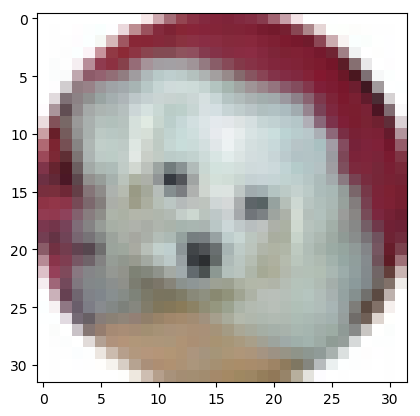

/home/titan/miniconda3/envs/deeplearn_project/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/titan/miniconda3/envs/deeplearn_project/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


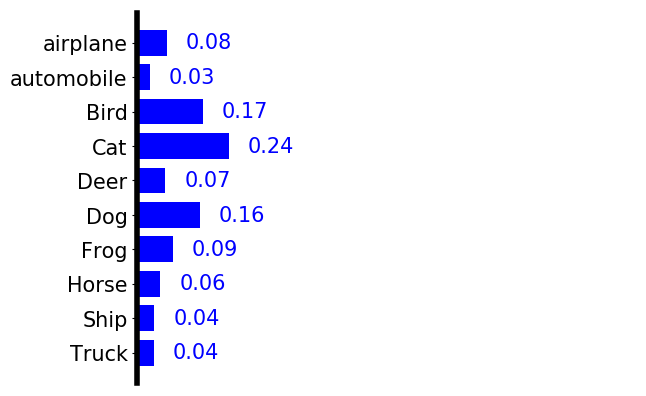

In [17]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
#im= (im-mean) / std
im=im.view(1,3,32,32)

# feed it to the net and display the confidence scores
scores =  net(im) 
probs= F.softmax(scores, dim=1)
utils.show_prob_cifar(probs.cpu())

In [18]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


from random import randint
import utils as ut 
import time

import numpy as np
import tensorflow as tf
from tensorflow.python.platform import flags
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms


#from util import get_normalized_data

from cleverhans.attacks import FastGradientMethod
from cleverhans.model import CallableModelWrapper
from cleverhans.utils import AccuracyReport
from cleverhans.utils_pytorch import convert_pytorch_model_to_tf


In [19]:
from utils import check_cifar_dataset_exists
data_path=check_cifar_dataset_exists()

train_data=torch.load(data_path+'cifar/train_data.pt')
train_label=torch.load(data_path+'cifar/train_label.pt')
test_data=torch.load(data_path+'cifar/test_data.pt')
test_label=torch.load(data_path+'cifar/test_label.pt')

print(train_data.size())
print(test_data.size())
print(train_data.type())
print(test_data.type())


torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
torch.FloatTensor
torch.FloatTensor


In [20]:
device= torch.device("cuda:1")
#device= torch.device("cpu")
print(device)


cuda:1


In [21]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096,4096)
        self.linear3 = nn.Linear(4096, 10)


    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x) 
        
        return x


In [22]:
net_vgg=VGG_convnet()

print(net_vgg)
ut.display_num_param(net_vgg)


VGG_convnet(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(i

In [23]:
criterion = nn.CrossEntropyLoss()
my_lr=0.25 
bs= 128

net_vgg = net_vgg.to(device)

In [ ]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        #inputs = (minibatch_data - mean)/std
        inputs = minibatch_data

        scores=net_vgg( inputs ) 

        error = ut.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1

    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')


# ### Do 20 passes through the training set. Divide the learning rate by 2 at epoch 10, 14 and 18.

# In[11]:


start=time.time()

for epoch in range(1,35):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if epoch==10 or epoch == 15 or epoch==25 or epoch==30:
        my_lr = my_lr / 2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net_vgg.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # normalize the minibatch (this is the only difference compared to before!)
        #inputs = (minibatch_data - mean)/std
        inputs = minibatch_data
        
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net_vgg( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = ut.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')
    
      

epoch= 1 	 time= 0.1771658976872762 min 	 lr= 0.25 	 loss= 2.3033349861574295 	 error= 90.08671674886932 percent
error rate on test set = 90.04153481012658 percent
 
epoch= 2 	 time= 0.3557172934214274 min 	 lr= 0.25 	 loss= 2.3017202167559767 	 error= 89.46930945986678 percent
error rate on test set = 90.11075949367088 percent
 
epoch= 3 	 time= 0.5366153200467427 min 	 lr= 0.25 	 loss= 2.3031061287121393 	 error= 89.96403452075656 percent
error rate on test set = 89.97231012658227 percent
 
epoch= 4 	 time= 0.7162699023882548 min 	 lr= 0.25 	 loss= 2.3010089055961354 	 error= 89.36580882962707 percent
error rate on test set = 90.11075949367088 percent
 
epoch= 5 	 time= 0.8868489503860474 min 	 lr= 0.25 	 loss= 2.301330021275279 	 error= 89.71867007977518 percent
error rate on test set = 90.04153481012658 percent
 
epoch= 6 	 time= 1.0547482212384542 min 	 lr= 0.25 	 loss= 2.2946108271703696 	 error= 88.97298592740619 percent
error rate on test set = 90.04153481012658 percent
 
epoch

In [25]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_label))
     
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_label))

sess = tf.Session()
x_op1 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))
#x_op2 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))


# Convert pytorch model to a tf_model and wrap it in cleverhans
tf_net = convert_pytorch_model_to_tf(net_vgg)
cleverhans_model = CallableModelWrapper(tf_net, output_layer='logits')




In [28]:
# Create an FGSM attack
fgsm_op = FastGradientMethod(cleverhans_model, sess=sess)
fgsm_params = {'eps': 0.3,
                 'clip_min': 0.,
                 'clip_max': 1.}
adv_x_op = fgsm_op.generate(x_op1, **fgsm_params)
adv_preds_op = tf_net(adv_x_op)


In [29]:
no_runs = 10000
correct = 0
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    adv_example = sess.run(adv_x_op, feed_dict={x_op1: xs})
    adv_preds = sess.run(adv_preds_op, feed_dict={adv_x_op: adv_example})
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()
   
acc = float(correct) / no_runs

print('Adversarial accuracy with FGSM attack: {:.3f}'.format(acc * 100))


Adversarial accuracy with FGSM attack: 10.000
